# ML Experiments in "Algebraic and Geometric Models for Space Networks"

In [32]:
from os_utilities import make_folder

from orb_builder import *
import soap_utilities as su
import report_parser as rp
import slice_analysis_nx as sanx # network x based
import slice_analysis as sagt # graph-tools based
from distances_tvg import *
from matrix import *
from ml_knn import *
from tle_utilities import starlink_exclude
from visualization import save_heatmap_gif

from tqdm import tqdm
from datetime import datetime
import itertools

# import tikzplotlib
# def tikzplotlib_fix_ncols(obj):
#     """
#     workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
#     """
#     if hasattr(obj, "_ncols"):
#         obj._ncol = obj._ncols
#     for child in obj.get_children():
#         tikzplotlib_fix_ncols(child)

In [30]:
folder_base = f"./outputs/experiments"
make_folder(folder_base)

date = datetime.now()

starlink = build_satellites_csv("starlink")

def filter_starlink(date, starlink):
    distance_min = 200
    distance_max = 800
    exclude_list = starlink_exclude(date, distance_min, distance_max)
    return list(filter(lambda sat : sat['object_name'] not in exclude_list, starlink))


# exclude_list = starlink_exclude(date, 200, 800)
# starlink_sats = list(filter(lambda sat : sat['object_name'] not in exclude_list, starlink))
starlink_sats = filter_starlink(date, starlink)

moon_sats = get_moon_platforms()
mars_sats = get_mars_platforms()
ground = [
    create_ground_object_dictionary("Ground-Albany", 42.685012663456163, -73.82479012295363, 0),
    create_ground_object_dictionary("Ground-Sydney", -33.868888888888889, 151.20939697339508, 0)
]
norad = build_satellites_from_tle("./sources/tdrss.tle")

def generate_orb_files(folder_name, name, satellites, date):
        save_to_outputs_file(
                generate_orb(satellites, name, date),
                f"experiments/{folder_name}/{name}", "orb")
        return name + ".orb"

## Average of $L(\mu^k)(i, j) = $ sum of intervals in entry $(i, j)$

Running Lifetime Matrix Simulations on Date = 2023-05-06 19:56:05.878862
Generating ORB Files
Running SOAP on ORB files


57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
57:66: execution error: 

Constructing Matrices from ORB Files


100%|██████████| 30/30 [00:01<00:00, 26.89it/s]


Average Dimension of 5-Satellite TVG Matrices is 4.533333333333333
The maximum diameter over 30 is 4


100%|██████████| 30/30 [00:01<00:00, 19.36it/s]


Average Dimension of 10-Satellite TVG Matrices is 9.933333333333334
The maximum diameter over 30 is 8


100%|██████████| 30/30 [00:03<00:00,  9.81it/s]


Average Dimension of 15-Satellite TVG Matrices is 14.866666666666667
The maximum diameter over 30 is 10


100%|██████████| 30/30 [00:06<00:00,  4.64it/s]


Average Dimension of 20-Satellite TVG Matrices is 19.8
The maximum diameter over 30 is 16


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Average Dimension of 25-Satellite TVG Matrices is 24.766666666666666
The maximum diameter over 30 is 16


100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Average Dimension of 30-Satellite TVG Matrices is 29.9
The maximum diameter over 30 is 20


100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


Average Dimension of 35-Satellite TVG Matrices is 34.666666666666664
The maximum diameter over 30 is 21


100%|██████████| 30/30 [01:37<00:00,  3.25s/it]


Average Dimension of 40-Satellite TVG Matrices is 39.733333333333334
The maximum diameter over 30 is 18
Saving Histograms
Calculating Walks
Calculating walks up to k = 21
Calculating Walks for 30 5-Satellite Systems


  7%|▋         | 2/30 [00:00<00:02, 13.09it/s]

len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 4
truncated frame_count=4 to 3


 13%|█▎        | 4/30 [00:00<00:02, 11.50it/s]

len(data_list) = 21 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2


 20%|██        | 6/30 [00:00<00:01, 14.04it/s]

len(data_list) = 21 | frame_count = 2


 30%|███       | 9/30 [00:00<00:01, 17.81it/s]

len(data_list) = 21 | frame_count = 2
truncated frame_count=2 to 1
len(data_list) = 21 | frame_count = 4
truncated frame_count=4 to 3


 43%|████▎     | 13/30 [00:00<00:01, 14.52it/s]

len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2


 50%|█████     | 15/30 [00:01<00:00, 15.26it/s]

len(data_list) = 21 | frame_count = 3


 57%|█████▋    | 17/30 [00:01<00:01, 12.14it/s]

len(data_list) = 21 | frame_count = 3
len(data_list) = 21 | frame_count = 2


 70%|███████   | 21/30 [00:01<00:00, 12.27it/s]

len(data_list) = 21 | frame_count = 3
len(data_list) = 21 | frame_count = 3
truncated frame_count=3 to 2
len(data_list) = 21 | frame_count = 3


 83%|████████▎ | 25/30 [00:01<00:00, 14.92it/s]

len(data_list) = 21 | frame_count = 2
truncated frame_count=2 to 1
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 4
truncated frame_count=4 to 3


 97%|█████████▋| 29/30 [00:02<00:00, 14.11it/s]

len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 2
len(data_list) = 21 | frame_count = 3


100%|██████████| 30/30 [00:02<00:00, 13.63it/s]


Calculating Walks for 30 10-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 21 | frame_count = 3


  7%|▋         | 2/30 [00:00<00:13,  2.02it/s]

len(data_list) = 21 | frame_count = 6


 10%|█         | 3/30 [00:01<00:15,  1.70it/s]

len(data_list) = 21 | frame_count = 8


 13%|█▎        | 4/30 [00:02<00:14,  1.76it/s]

len(data_list) = 21 | frame_count = 6


 17%|█▋        | 5/30 [00:02<00:12,  2.01it/s]

len(data_list) = 21 | frame_count = 5


 20%|██        | 6/30 [00:02<00:10,  2.31it/s]

len(data_list) = 21 | frame_count = 4


 23%|██▎       | 7/30 [00:03<00:09,  2.38it/s]

len(data_list) = 21 | frame_count = 6


 27%|██▋       | 8/30 [00:03<00:11,  1.94it/s]

len(data_list) = 21 | frame_count = 6


 30%|███       | 9/30 [00:04<00:09,  2.25it/s]

len(data_list) = 21 | frame_count = 4


 33%|███▎      | 10/30 [00:04<00:08,  2.27it/s]

len(data_list) = 21 | frame_count = 5


 37%|███▋      | 11/30 [00:05<00:08,  2.33it/s]

len(data_list) = 21 | frame_count = 4


 40%|████      | 12/30 [00:05<00:07,  2.49it/s]

len(data_list) = 21 | frame_count = 5


 43%|████▎     | 13/30 [00:05<00:06,  2.55it/s]

len(data_list) = 21 | frame_count = 4


 47%|████▋     | 14/30 [00:06<00:06,  2.56it/s]

len(data_list) = 21 | frame_count = 5


 50%|█████     | 15/30 [00:06<00:05,  2.63it/s]

len(data_list) = 21 | frame_count = 4


 53%|█████▎    | 16/30 [00:06<00:05,  2.62it/s]

len(data_list) = 21 | frame_count = 5


 57%|█████▋    | 17/30 [00:07<00:05,  2.54it/s]

len(data_list) = 21 | frame_count = 6


 60%|██████    | 18/30 [00:07<00:04,  2.76it/s]

len(data_list) = 21 | frame_count = 3


 63%|██████▎   | 19/30 [00:07<00:03,  2.82it/s]

len(data_list) = 21 | frame_count = 4


 67%|██████▋   | 20/30 [00:08<00:04,  2.40it/s]

len(data_list) = 21 | frame_count = 7


 70%|███████   | 21/30 [00:09<00:04,  2.20it/s]

len(data_list) = 21 | frame_count = 5


 73%|███████▎  | 22/30 [00:09<00:03,  2.27it/s]

len(data_list) = 21 | frame_count = 5


 77%|███████▋  | 23/30 [00:09<00:02,  2.46it/s]

len(data_list) = 21 | frame_count = 4


 80%|████████  | 24/30 [00:10<00:02,  2.13it/s]

len(data_list) = 21 | frame_count = 6


 83%|████████▎ | 25/30 [00:11<00:02,  1.75it/s]

len(data_list) = 21 | frame_count = 7


 87%|████████▋ | 26/30 [00:11<00:02,  1.82it/s]

len(data_list) = 21 | frame_count = 6


 90%|█████████ | 27/30 [00:12<00:01,  2.06it/s]

len(data_list) = 21 | frame_count = 4


 93%|█████████▎| 28/30 [00:12<00:00,  2.25it/s]

len(data_list) = 21 | frame_count = 6


 97%|█████████▋| 29/30 [00:12<00:00,  2.58it/s]

len(data_list) = 21 | frame_count = 4


100%|██████████| 30/30 [00:13<00:00,  2.29it/s]


len(data_list) = 21 | frame_count = 5
Calculating Walks for 30 15-Satellite Systems


  3%|▎         | 1/30 [00:01<00:43,  1.50s/it]

len(data_list) = 21 | frame_count = 7


  7%|▋         | 2/30 [00:03<00:55,  1.99s/it]

len(data_list) = 21 | frame_count = 10


 10%|█         | 3/30 [00:05<00:51,  1.90s/it]

len(data_list) = 21 | frame_count = 9


 13%|█▎        | 4/30 [00:06<00:42,  1.63s/it]

len(data_list) = 21 | frame_count = 7


 17%|█▋        | 5/30 [00:08<00:37,  1.50s/it]

len(data_list) = 21 | frame_count = 6


 20%|██        | 6/30 [00:11<00:47,  1.98s/it]

len(data_list) = 21 | frame_count = 8


 23%|██▎       | 7/30 [00:12<00:44,  1.94s/it]

len(data_list) = 21 | frame_count = 9


 27%|██▋       | 8/30 [00:14<00:40,  1.84s/it]

len(data_list) = 21 | frame_count = 8


 30%|███       | 9/30 [00:15<00:32,  1.56s/it]

len(data_list) = 21 | frame_count = 7


 33%|███▎      | 10/30 [00:17<00:32,  1.61s/it]

len(data_list) = 21 | frame_count = 8


 37%|███▋      | 11/30 [00:17<00:25,  1.32s/it]

len(data_list) = 21 | frame_count = 4


 40%|████      | 12/30 [00:20<00:33,  1.86s/it]

len(data_list) = 21 | frame_count = 10


 43%|████▎     | 13/30 [00:23<00:34,  2.05s/it]

len(data_list) = 21 | frame_count = 10
truncated frame_count=10 to 9


 47%|████▋     | 14/30 [00:25<00:31,  1.95s/it]

len(data_list) = 21 | frame_count = 9


 50%|█████     | 15/30 [00:27<00:29,  1.94s/it]

len(data_list) = 21 | frame_count = 8


 53%|█████▎    | 16/30 [00:28<00:27,  1.93s/it]

len(data_list) = 21 | frame_count = 8


 57%|█████▋    | 17/30 [00:30<00:24,  1.86s/it]

len(data_list) = 21 | frame_count = 10


 60%|██████    | 18/30 [00:32<00:22,  1.84s/it]

len(data_list) = 21 | frame_count = 9


 63%|██████▎   | 19/30 [00:34<00:20,  1.86s/it]

len(data_list) = 21 | frame_count = 10
truncated frame_count=10 to 9


 67%|██████▋   | 20/30 [00:35<00:17,  1.72s/it]

len(data_list) = 21 | frame_count = 9


 70%|███████   | 21/30 [00:37<00:16,  1.79s/it]

len(data_list) = 21 | frame_count = 8


 73%|███████▎  | 22/30 [00:39<00:13,  1.64s/it]

len(data_list) = 21 | frame_count = 8


 77%|███████▋  | 23/30 [00:40<00:10,  1.57s/it]

len(data_list) = 21 | frame_count = 8


 80%|████████  | 24/30 [00:42<00:09,  1.60s/it]

len(data_list) = 21 | frame_count = 5


 83%|████████▎ | 25/30 [00:43<00:08,  1.63s/it]

len(data_list) = 21 | frame_count = 9


 87%|████████▋ | 26/30 [00:45<00:06,  1.66s/it]

len(data_list) = 21 | frame_count = 9


 90%|█████████ | 27/30 [00:46<00:04,  1.54s/it]

len(data_list) = 21 | frame_count = 9


 93%|█████████▎| 28/30 [00:47<00:02,  1.37s/it]

len(data_list) = 21 | frame_count = 5


 97%|█████████▋| 29/30 [00:49<00:01,  1.38s/it]

len(data_list) = 21 | frame_count = 10


100%|██████████| 30/30 [00:51<00:00,  1.70s/it]


len(data_list) = 21 | frame_count = 7
Calculating Walks for 30 20-Satellite Systems


  3%|▎         | 1/30 [00:07<03:40,  7.59s/it]

len(data_list) = 21 | frame_count = 10


  7%|▋         | 2/30 [00:12<02:44,  5.87s/it]

len(data_list) = 21 | frame_count = 10


 10%|█         | 3/30 [00:14<01:59,  4.42s/it]

len(data_list) = 21 | frame_count = 12
len(data_list) = 21 | frame_count = 16


 17%|█▋        | 5/30 [00:28<02:22,  5.71s/it]

len(data_list) = 21 | frame_count = 10


 20%|██        | 6/30 [00:35<02:21,  5.90s/it]

len(data_list) = 21 | frame_count = 11


 23%|██▎       | 7/30 [00:39<02:01,  5.29s/it]

len(data_list) = 21 | frame_count = 11


 27%|██▋       | 8/30 [00:45<02:04,  5.66s/it]

len(data_list) = 21 | frame_count = 12


 30%|███       | 9/30 [00:50<01:53,  5.40s/it]

len(data_list) = 21 | frame_count = 13


 33%|███▎      | 10/30 [00:55<01:43,  5.15s/it]

len(data_list) = 21 | frame_count = 10


 37%|███▋      | 11/30 [01:01<01:44,  5.52s/it]

len(data_list) = 21 | frame_count = 12


 40%|████      | 12/30 [01:05<01:31,  5.07s/it]

len(data_list) = 21 | frame_count = 11


 43%|████▎     | 13/30 [01:12<01:35,  5.63s/it]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


 47%|████▋     | 14/30 [01:16<01:21,  5.08s/it]

len(data_list) = 21 | frame_count = 11
len(data_list) = 21 | frame_count = 14


 53%|█████▎    | 16/30 [01:25<01:05,  4.67s/it]

len(data_list) = 21 | frame_count = 12


 57%|█████▋    | 17/30 [01:28<00:55,  4.29s/it]

len(data_list) = 21 | frame_count = 9
len(data_list) = 21 | frame_count = 13


 60%|██████    | 18/30 [01:32<00:51,  4.31s/it]

len(data_list) = 21 | frame_count = 13


 67%|██████▋   | 20/30 [01:44<00:50,  5.06s/it]

len(data_list) = 21 | frame_count = 11


 70%|███████   | 21/30 [01:48<00:43,  4.83s/it]

len(data_list) = 21 | frame_count = 8


 73%|███████▎  | 22/30 [01:53<00:39,  4.93s/it]

len(data_list) = 21 | frame_count = 9


 77%|███████▋  | 23/30 [01:56<00:30,  4.31s/it]

len(data_list) = 21 | frame_count = 12


 80%|████████  | 24/30 [02:00<00:24,  4.07s/it]

len(data_list) = 21 | frame_count = 11


 83%|████████▎ | 25/30 [02:03<00:19,  3.95s/it]

len(data_list) = 21 | frame_count = 11


 87%|████████▋ | 26/30 [02:09<00:17,  4.39s/it]

len(data_list) = 21 | frame_count = 12


 90%|█████████ | 27/30 [02:15<00:14,  4.81s/it]

len(data_list) = 21 | frame_count = 13


 93%|█████████▎| 28/30 [02:22<00:11,  5.54s/it]

len(data_list) = 21 | frame_count = 12


 97%|█████████▋| 29/30 [02:27<00:05,  5.43s/it]

len(data_list) = 21 | frame_count = 10
truncated frame_count=10 to 9
len(data_list) = 21 | frame_count = 14


100%|██████████| 30/30 [02:32<00:00,  5.07s/it]


Calculating Walks for 30 25-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


  3%|▎         | 1/30 [00:12<05:48, 12.02s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


  7%|▋         | 2/30 [00:24<05:38, 12.11s/it]

len(data_list) = 21 | frame_count = 14


 10%|█         | 3/30 [00:37<05:41, 12.64s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 13%|█▎        | 4/30 [00:47<05:06, 11.78s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 17%|█▋        | 5/30 [01:00<05:02, 12.09s/it]

len(data_list) = 21 | frame_count = 14


 23%|██▎       | 7/30 [01:24<04:34, 11.95s/it]

len(data_list) = 21 | frame_count = 12
len(data_list) = 21 | frame_count = 13


 30%|███       | 9/30 [01:43<03:43, 10.67s/it]

len(data_list) = 21 | frame_count = 12
len(data_list) = 21 | frame_count = 13


 33%|███▎      | 10/30 [01:53<03:25, 10.30s/it]

len(data_list) = 21 | frame_count = 15


 40%|████      | 12/30 [02:18<03:23, 11.33s/it]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


 43%|████▎     | 13/30 [02:28<03:06, 10.95s/it]

len(data_list) = 21 | frame_count = 12
len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 47%|████▋     | 14/30 [02:42<03:08, 11.79s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 50%|█████     | 15/30 [02:53<02:54, 11.61s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 53%|█████▎    | 16/30 [03:05<02:47, 11.94s/it]

len(data_list) = 21 | frame_count = 14


 57%|█████▋    | 17/30 [03:16<02:28, 11.41s/it]

len(data_list) = 21 | frame_count = 16


 60%|██████    | 18/30 [03:28<02:18, 11.54s/it]

len(data_list) = 21 | frame_count = 14


 67%|██████▋   | 20/30 [03:50<01:52, 11.26s/it]

len(data_list) = 21 | frame_count = 11
len(data_list) = 21 | frame_count = 13


 70%|███████   | 21/30 [04:05<01:52, 12.47s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 77%|███████▋  | 23/30 [04:26<01:21, 11.59s/it]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


 80%|████████  | 24/30 [04:41<01:14, 12.49s/it]

len(data_list) = 21 | frame_count = 12
len(data_list) = 21 | frame_count = 14


 83%|████████▎ | 25/30 [04:54<01:03, 12.78s/it]

len(data_list) = 21 | frame_count = 15


 87%|████████▋ | 26/30 [05:09<00:53, 13.38s/it]

len(data_list) = 21 | frame_count = 13


 90%|█████████ | 27/30 [05:21<00:38, 12.88s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 93%|█████████▎| 28/30 [05:33<00:25, 12.77s/it]

len(data_list) = 21 | frame_count = 13


 97%|█████████▋| 29/30 [05:41<00:11, 11.39s/it]

len(data_list) = 21 | frame_count = 13


100%|██████████| 30/30 [05:55<00:00, 11.87s/it]


Calculating Walks for 30 30-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


  3%|▎         | 1/30 [00:23<11:28, 23.73s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


  7%|▋         | 2/30 [00:45<10:27, 22.41s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 10%|█         | 3/30 [01:07<10:06, 22.47s/it]

len(data_list) = 21 | frame_count = 14


 13%|█▎        | 4/30 [01:30<09:50, 22.72s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 17%|█▋        | 5/30 [01:53<09:28, 22.75s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 20%|██        | 6/30 [02:27<10:39, 26.65s/it]

len(data_list) = 21 | frame_count = 13


 23%|██▎       | 7/30 [02:45<09:02, 23.60s/it]

len(data_list) = 21 | frame_count = 16


 27%|██▋       | 8/30 [03:05<08:17, 22.62s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 30%|███       | 9/30 [03:25<07:35, 21.71s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 33%|███▎      | 10/30 [03:49<07:28, 22.43s/it]

len(data_list) = 21 | frame_count = 16


 37%|███▋      | 11/30 [04:12<07:09, 22.58s/it]

len(data_list) = 21 | frame_count = 20
truncated frame_count=20 to 19


 40%|████      | 12/30 [04:36<06:55, 23.09s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 43%|████▎     | 13/30 [04:57<06:23, 22.55s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 47%|████▋     | 14/30 [05:22<06:07, 23.00s/it]

len(data_list) = 21 | frame_count = 15


 50%|█████     | 15/30 [05:39<05:18, 21.21s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 53%|█████▎    | 16/30 [06:04<05:13, 22.41s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 57%|█████▋    | 17/30 [06:24<04:42, 21.76s/it]

len(data_list) = 21 | frame_count = 16


 60%|██████    | 18/30 [06:43<04:09, 20.80s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 63%|██████▎   | 19/30 [07:04<03:51, 21.08s/it]

len(data_list) = 21 | frame_count = 16


 67%|██████▋   | 20/30 [07:30<03:45, 22.56s/it]

len(data_list) = 21 | frame_count = 15


 70%|███████   | 21/30 [07:48<03:11, 21.23s/it]

len(data_list) = 21 | frame_count = 17


 73%|███████▎  | 22/30 [08:13<02:56, 22.09s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 77%|███████▋  | 23/30 [08:32<02:29, 21.39s/it]

len(data_list) = 21 | frame_count = 18


 80%|████████  | 24/30 [08:57<02:13, 22.24s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 83%|████████▎ | 25/30 [09:15<01:45, 21.06s/it]

len(data_list) = 21 | frame_count = 13


 87%|████████▋ | 26/30 [09:41<01:30, 22.52s/it]

len(data_list) = 21 | frame_count = 16


 90%|█████████ | 27/30 [10:02<01:06, 22.16s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 93%|█████████▎| 28/30 [10:27<00:45, 22.94s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 97%|█████████▋| 29/30 [10:58<00:25, 25.37s/it]

len(data_list) = 21 | frame_count = 14


100%|██████████| 30/30 [11:23<00:00, 22.80s/it]


Calculating Walks for 30 35-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 21 | frame_count = 16


  3%|▎         | 1/30 [00:35<17:01, 35.22s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


  7%|▋         | 2/30 [01:06<15:14, 32.68s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 10%|█         | 3/30 [01:42<15:25, 34.29s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 13%|█▎        | 4/30 [02:13<14:24, 33.25s/it]

len(data_list) = 21 | frame_count = 17


 17%|█▋        | 5/30 [02:37<12:24, 29.79s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 20%|██        | 6/30 [03:08<12:01, 30.08s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 23%|██▎       | 7/30 [03:39<11:41, 30.52s/it]

len(data_list) = 21 | frame_count = 18


 27%|██▋       | 8/30 [04:20<12:23, 33.80s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 30%|███       | 9/30 [04:55<11:57, 34.15s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 33%|███▎      | 10/30 [05:27<11:08, 33.44s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 37%|███▋      | 11/30 [06:01<10:39, 33.63s/it]

len(data_list) = 21 | frame_count = 17


 40%|████      | 12/30 [06:40<10:36, 35.34s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 43%|████▎     | 13/30 [07:22<10:36, 37.46s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 47%|████▋     | 14/30 [07:54<09:28, 35.55s/it]

len(data_list) = 21 | frame_count = 18


 50%|█████     | 15/30 [08:24<08:30, 34.02s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 53%|█████▎    | 16/30 [09:01<08:09, 34.95s/it]

len(data_list) = 21 | frame_count = 15


 57%|█████▋    | 17/30 [09:35<07:28, 34.50s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 60%|██████    | 18/30 [09:55<06:04, 30.34s/it]

len(data_list) = 21 | frame_count = 19
truncated frame_count=19 to 18


 63%|██████▎   | 19/30 [10:34<06:00, 32.74s/it]

len(data_list) = 21 | frame_count = 21


 67%|██████▋   | 20/30 [11:11<05:39, 34.00s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 70%|███████   | 21/30 [11:43<05:00, 33.44s/it]

len(data_list) = 21 | frame_count = 16


 73%|███████▎  | 22/30 [12:16<04:27, 33.48s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 77%|███████▋  | 23/30 [12:43<03:40, 31.43s/it]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


 80%|████████  | 24/30 [13:13<03:06, 31.03s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 83%|████████▎ | 25/30 [13:42<02:32, 30.57s/it]

len(data_list) = 21 | frame_count = 15


 87%|████████▋ | 26/30 [14:13<02:02, 30.53s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 90%|█████████ | 27/30 [14:50<01:37, 32.46s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 93%|█████████▎| 28/30 [15:22<01:04, 32.24s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 97%|█████████▋| 29/30 [15:55<00:32, 32.70s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


100%|██████████| 30/30 [16:24<00:00, 32.80s/it]


Calculating Walks for 30 40-Satellite Systems


  0%|          | 0/30 [00:00<?, ?it/s]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


  3%|▎         | 1/30 [00:45<21:45, 45.02s/it]

len(data_list) = 21 | frame_count = 16


  7%|▋         | 2/30 [01:28<20:34, 44.10s/it]

len(data_list) = 21 | frame_count = 13


 10%|█         | 3/30 [02:10<19:27, 43.25s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 13%|█▎        | 4/30 [02:58<19:27, 44.91s/it]

len(data_list) = 21 | frame_count = 15


 17%|█▋        | 5/30 [03:37<17:51, 42.87s/it]

len(data_list) = 21 | frame_count = 17


 20%|██        | 6/30 [04:33<18:59, 47.50s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 23%|██▎       | 7/30 [05:11<16:57, 44.24s/it]

len(data_list) = 21 | frame_count = 14


 27%|██▋       | 8/30 [05:59<16:40, 45.47s/it]

len(data_list) = 21 | frame_count = 13
truncated frame_count=13 to 12


 30%|███       | 9/30 [06:36<15:01, 42.95s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 33%|███▎      | 10/30 [07:26<15:02, 45.13s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 37%|███▋      | 11/30 [08:11<14:13, 44.93s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 40%|████      | 12/30 [08:55<13:23, 44.64s/it]

len(data_list) = 21 | frame_count = 15


 43%|████▎     | 13/30 [09:32<11:59, 42.35s/it]

len(data_list) = 21 | frame_count = 15
truncated frame_count=15 to 14


 47%|████▋     | 14/30 [10:11<11:02, 41.40s/it]

len(data_list) = 21 | frame_count = 16


 50%|█████     | 15/30 [10:59<10:48, 43.20s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 53%|█████▎    | 16/30 [11:39<09:54, 42.49s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 57%|█████▋    | 17/30 [12:21<09:08, 42.22s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 60%|██████    | 18/30 [13:06<08:35, 42.99s/it]

len(data_list) = 21 | frame_count = 16


 63%|██████▎   | 19/30 [13:47<07:47, 42.48s/it]

len(data_list) = 21 | frame_count = 18
truncated frame_count=18 to 17


 67%|██████▋   | 20/30 [14:34<07:18, 43.80s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 70%|███████   | 21/30 [15:19<06:38, 44.30s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 73%|███████▎  | 22/30 [16:00<05:44, 43.12s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 77%|███████▋  | 23/30 [16:53<05:23, 46.19s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


 80%|████████  | 24/30 [17:26<04:12, 42.05s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 83%|████████▎ | 25/30 [18:11<03:35, 43.08s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 87%|████████▋ | 26/30 [18:59<02:57, 44.46s/it]

len(data_list) = 21 | frame_count = 17


 90%|█████████ | 27/30 [19:46<02:15, 45.25s/it]

len(data_list) = 21 | frame_count = 16
truncated frame_count=16 to 15


 93%|█████████▎| 28/30 [20:25<01:27, 43.55s/it]

len(data_list) = 21 | frame_count = 14
truncated frame_count=14 to 13


 97%|█████████▋| 29/30 [21:07<00:42, 42.92s/it]

len(data_list) = 21 | frame_count = 17
truncated frame_count=17 to 16


100%|██████████| 30/30 [21:47<00:00, 43.57s/it]


Calculating Distances


100%|██████████| 30/30 [54:19<00:00, 108.66s/it]  


Plotting Aggregates Overlay and Confidence Interval


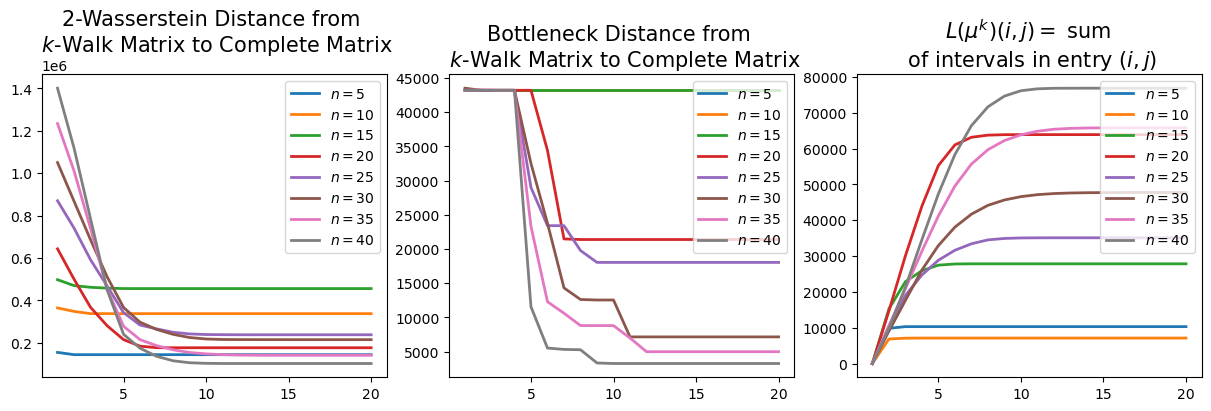

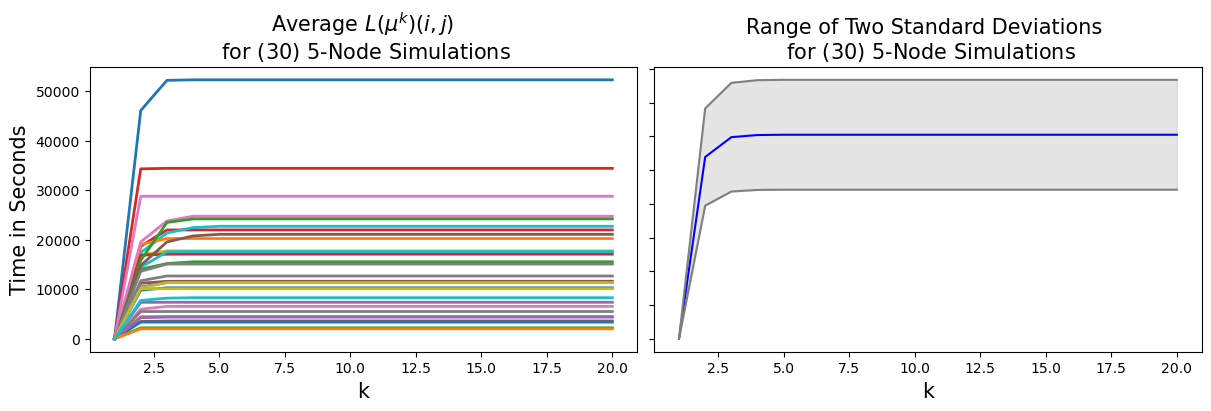

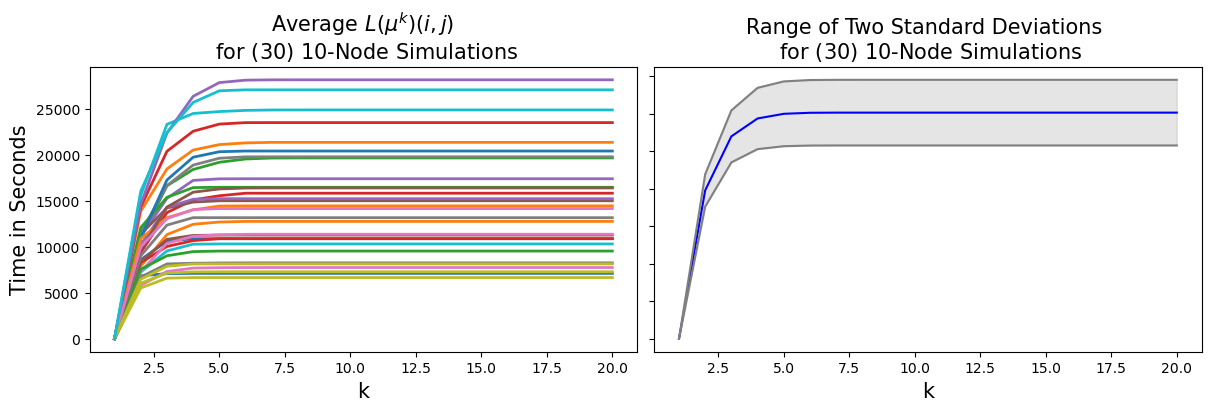

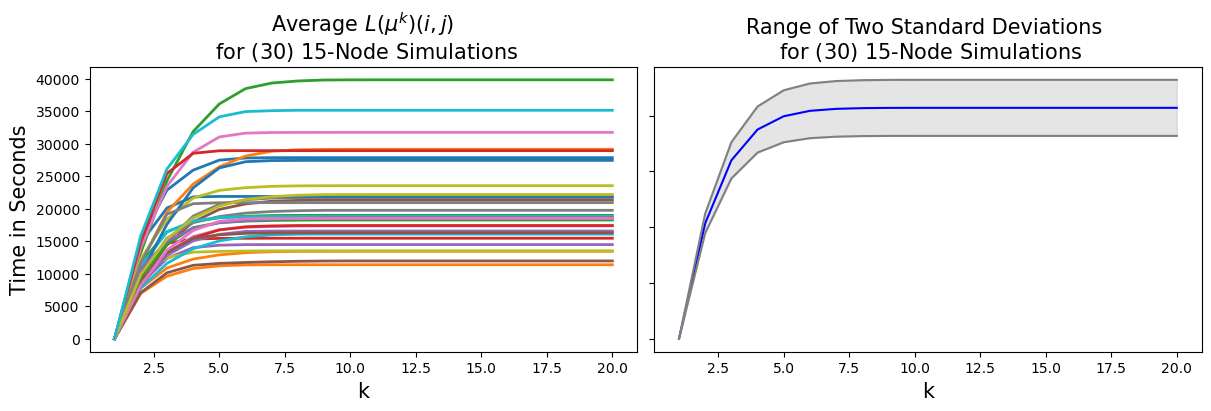

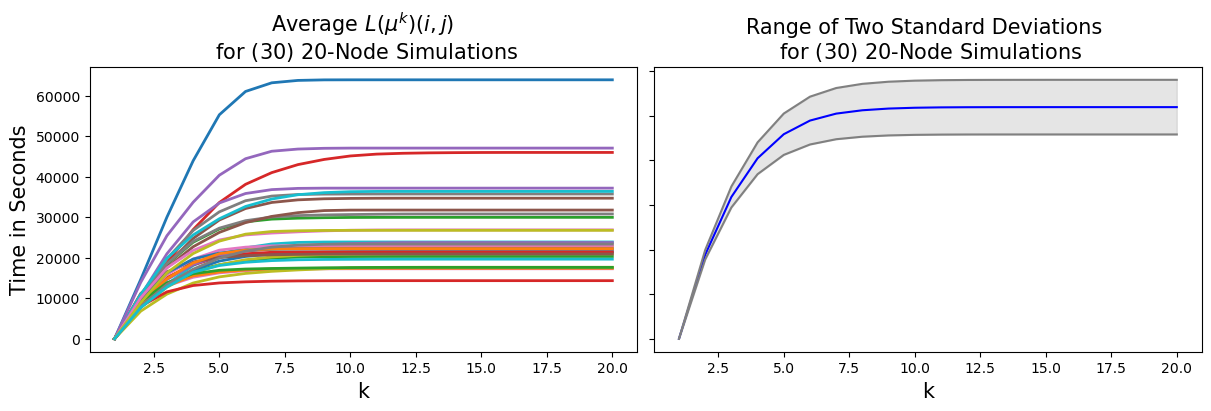

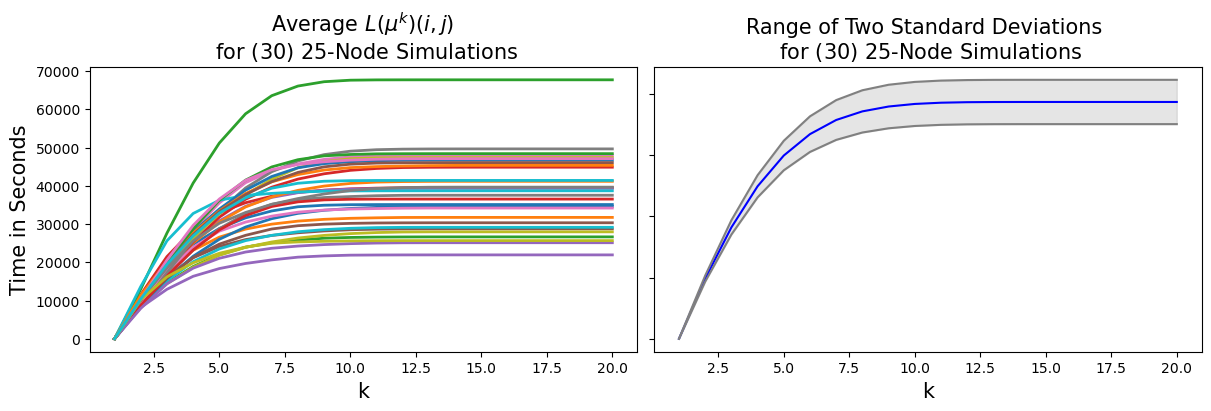

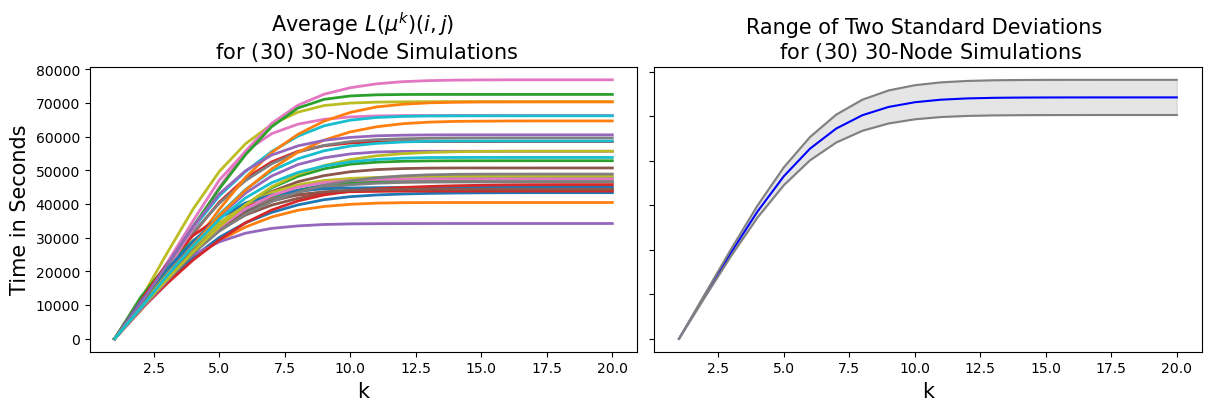

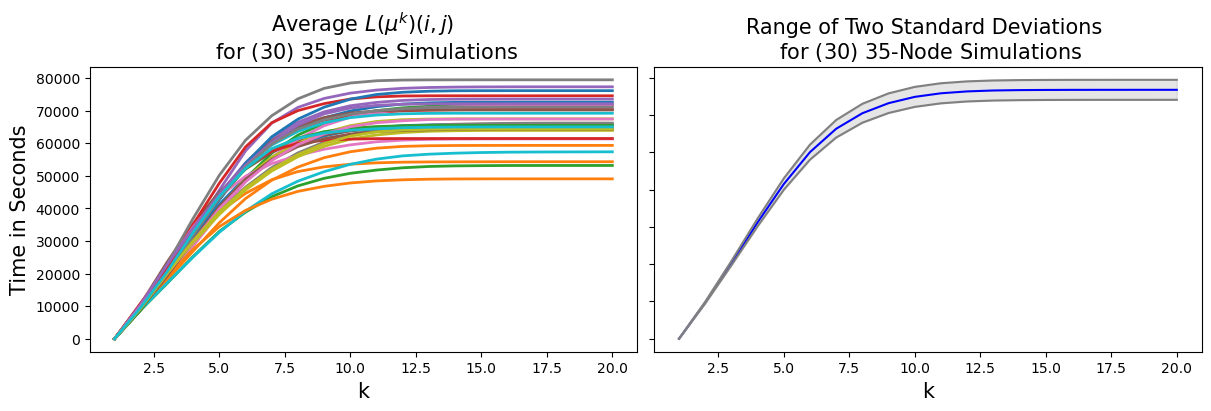

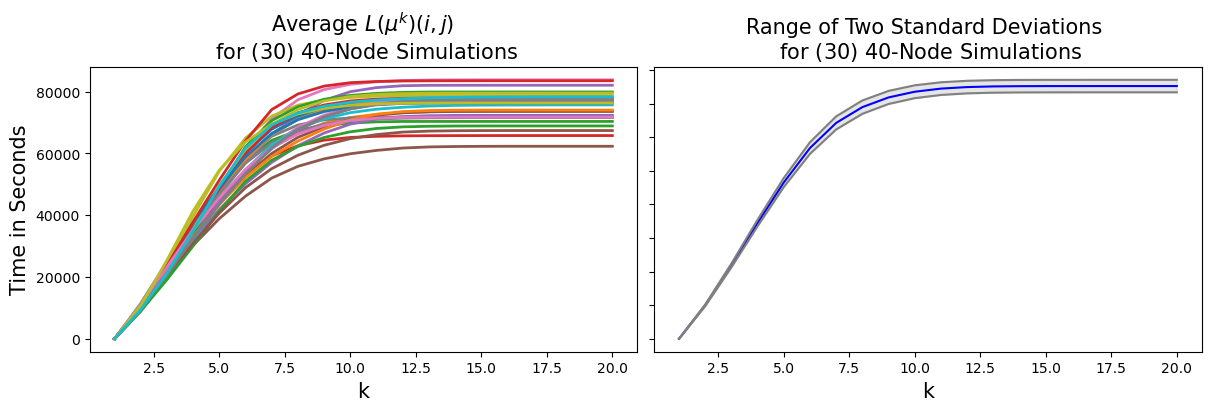

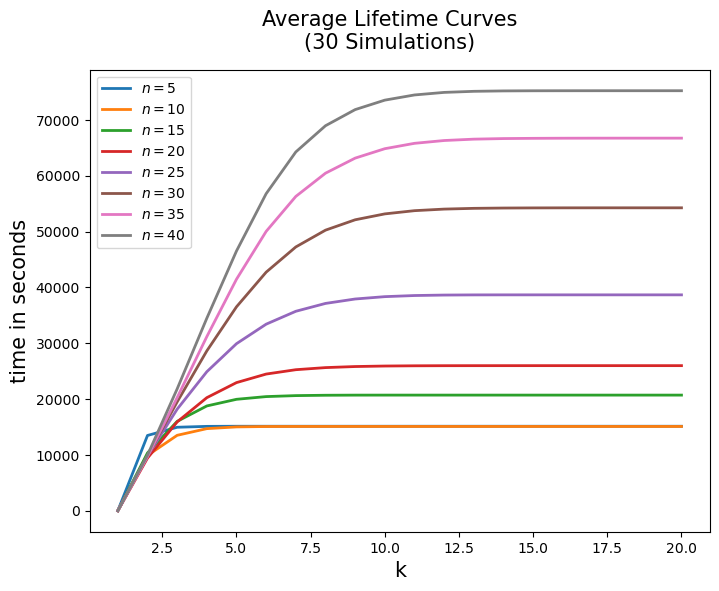

In [27]:
n_list = [20, 30, 40, 50, 70, 100] # Figure 5, 7
n_list = [5, 10, 15, 20, 25, 30, 35, 40] # Figure 8
# n_list = [5, 10, 15, 20, 50]
# n_list = [5, 10]
simulation_count = 30
# simulation_count = 2

date = datetime.now()
print(f"Running Lifetime Matrix Simulations on Date = {date}")

print(f"Generating ORB Files")

folder_names = []
orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"lt-starlink-{n}-sat-single"
    folder_names.append(folder_name)
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y_%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

print(f"Constructing Matrices from ORB Files")
A = [[] for n in n_list]
B = [[] for n in n_list]
m = [[] for n in n_list] # dimensions of the matrices
max_diameter = [[] for n in n_list]
max_diameter_time = [[] for n in n_list]
max_diameter_sg = [[] for n in n_list]

diameters = [[] for n in n_list] # for histograms
sample_times = [[] for n in n_list] # for histograms

for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    # diagrams[i] = {}
    dim_sum = 0
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        filepath = path.replace(".orb", " Contact Analysis.csv")

        matrix = rp.soap_converter(filepath)
        A[i].append(matrix)
        B[i].append(IntervalMatrix.complete_matrix(matrix.dim_row))
        m[i].append(matrix.dim_row)

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        critical_times = rp.extract_critical_times(tvg)
        sample_times_ij = rp.sample_critical_times(critical_times)

        diameter, time, sg, diameters_ij = sanx.get_max_diameter(tvg, sample_times_ij)

        max_diameter[i].append(diameter)
        max_diameter_time[i].append(time)
        max_diameter_sg[i].append(sg)

        sample_times[i].append(sample_times_ij)
        diameters[i].append(diameters_ij)

        sanx.save_figure(sg, 
            f"{folder_base}/{folder_name}/{orb_filename}_max_graph_diameter.png")

        dim_sum += matrix.dim_row

    print(f"Average Dimension of {n}-Satellite TVG Matrices is {dim_sum / len(orb_paths[i])}")
    print(f"The maximum diameter over {len(orb_paths[i])} is {max(max_diameter[i])}")

print(f"Saving Histograms")

for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    for j, path in enumerate(orb_paths[i]):
        orb_filename = path.replace(".orb", "").split("/")[-1]

        sample_times_ij = sample_times[i][j]
        diameters_ij = diameters[i][j]

        fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
        # fig.tight_layout(pad=10.0)

        hist = axs[0].hist(diameters_ij)
        axs[0].set_xlabel("Slice Diameter")
        axs[0].set_ylabel("Slice Count")
        axs[0].set_title("Histogram of Diameters")

        axs[1].plot(sample_times_ij, diameters_ij)
        axs[1].set_xlabel("Slice Time (s)")
        axs[1].set_ylabel("Slice Diameter")
        axs[1].set_title("Graph of TVG Diameter")

        fig.suptitle(f"Diameters of {n}-Node System")

        plt.savefig(f"{folder_base}/{folder_name}/{orb_filename}_diameter_histogram.png")
        plt.close(fig)


print(f"Calculating Walks")

start_time, end_time = 0, 86400

walk_length = max([max(max_diameter[i]) for i in range(len(n_list))])
print(f"Calculating walks up to k = {walk_length}")

walks = [[] for n in n_list]

# for i, n in enumerate([]):
for i, n in enumerate(n_list):
    folder_name = folder_names[i]
    
    print(f"Calculating Walks for {len(orb_paths[i])} {n}-Satellite Systems")
    for j, path in enumerate(tqdm(orb_paths[i])):
        orb_filename = path.replace(".orb", "").split("/")[-1]
        walks[i].append([IntervalMatrix.identity_matrix(m[i][j])])

        adjacency_matrices_max_diameter = []

        # print(f"Calculating Walks for {j}-th {n}-Satellite System")
        for k in range(walk_length):
            # print("\tCalculating {}-Walks for {}-th {}-Sat system".format(k, i, n))
            if k == 0:
                A_k = A[i][j]
            else:
                A_k = A[i][j] * walks[i][j][-1]

            tvg_slice = A_k.get_slice_at(max_diameter_time[i][j])
            adjacency_matrices_max_diameter.append(np.array(tvg_slice))

            walks[i][j].append(A_k)

        filepath = f"{folder_base}/{folder_name}/{orb_filename}_heatmap.gif"
        if max_diameter[i][j] > 1:
            save_heatmap_gif(adjacency_matrices_max_diameter, m[i][j], max_diameter[i][j], filepath)


# Calculating Distances
print(f"Calculating Distances")
lifetime_list = [[] for n in n_list]
bdist = [None for n in n_list]
wdist_2 = [None for n in n_list]

for i, n in enumerate(n_list):
    bdist[i] = [None for j in orb_paths[i]]
    wdist_2[i] = [None for j in orb_paths[i]]

    for j, path in enumerate(tqdm(orb_paths[i])):
        bdist[i][j] = [-1 for k in range(1, walk_length)]
        wdist_2[i][j] = [-1 for k in range(1, walk_length)]

        # print(f"{i}:{j} : {path}")

        for k in range(1, walk_length):
            A_k = walks[i][j][k]
            B_k = B[i][j]
            # B_k = IntervalMatrix.complete_matrix(n)

            diagram_a_k = tvg_to_complement_diagram_matrix(A_k, start_time, end_time)
            diagram_b_k = tvg_to_complement_diagram_matrix(B_k, start_time, end_time)

            distance = tvg_interval_bottleneck_distance_matrix(diagram_a_k, diagram_b_k, m[i][j])
            bdist[i][j][k - 1] = sup_norm(distance)

            distance = tvg_interval_wasserstein_distance_matrix(diagram_a_k, diagram_b_k, m[i][j], 2)
            wdist_2[i][j][k - 1] = q_norm(distance, 2)

        # Lifetime Matrix
        L = tvg_lifetime_matrix(walks[i][j], start_time, end_time, walk_length)

        y_list = generate_y_list(L, walks[i][j][0].dim_row, walk_length)
        y_list_average = calculate_y_list_average(y_list, walk_length)
        lifetime_list[i].append(y_list_average)

# Plot Aggregates
print(f"Plotting Aggregates Overlay and Confidence Interval")

x = list(range(1, walk_length))

# Plot Wasserstein and Bottleneck Distances to Complete Matrices (First, j=0)
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(12, 4))
axs[0].set_title(f"2-Wasserstein Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[1].set_title(f"Bottleneck Distance from \n $k$-Walk Matrix to Complete Matrix", fontsize=15)
axs[2].set_title(f"$L(\mu^k)(i, j) = $ sum \n of intervals in entry $(i, j)$", fontsize=15)

for i, n in enumerate(n_list):
    distance = wdist_2[i][0]
    axs[0].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    distance = bdist[i][0]
    axs[1].plot(x, distance, linewidth=2, label=f"$n = {n}$")

    coverage = lifetime_list[i][0][1:]
    axs[2].plot(x, coverage, linewidth=2, label=f"$n = {n}$")

axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")
axs[2].legend(loc="upper right")

# tikzplotlib_fix_ncols(plt.gcf())
# tikzplotlib.save(f"{folder_base}/algebraic_distances_overlay_today_test.tex")
plt.savefig(f"{folder_base}/algebraic_distances_overlay_today_test.png")
plt.show()

# Plot Lifetime Distances and Confidence Intervals
mean_list = [[] for n in n_list]
for i, n in enumerate(n_list):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

    # axs[0].set_xlabel("k", fontsize=15)
    # axs[0].set_ylabel('Time in Seconds', fontsize=15)
    axs[0].set_title(f"Average $L(\mu^k)(i, j)$ \n for $({len(orb_paths[i])})$ ${n}$-Node Simulations", fontsize=15)

    # ax1.plot(x, lifetime_list[i][0][1:], linewidth=2) # plot first only
    for j, path in enumerate(orb_paths[i]):
        axs[0].plot(x, lifetime_list[i][j][1:], linewidth=2)
    # labels.append(f"$n = {n}$")

    lower_list = []
    upper_list = []

    for k in range(1, walk_length):
        data = []
        for j in range(1, len(lifetime_list[i])):
            data.append(lifetime_list[i][j][k])
        # mean, lower, upper = confidence_interval(data)
        mean, lower, upper = error_bars(data)
        
        mean_list[i].append(mean)
        lower_list.append(lower)
        upper_list.append(upper)

    # axs[1].set_xlabel("k", fontsize=15)
    # axs[1].set_ylabel("Time in Seconds", fontsize=15)
    axs[1].set_title(f"Range of Two Standard Deviations \n for $({len(orb_paths[i])})$ {n}-Node Simulations", fontsize=15)

    axs[1].plot(x, mean_list[i], color="blue")
    axs[1].plot(x, lower_list, color="grey")
    axs[1].plot(x, upper_list, color="grey")

    for ax in axs.flat:
        ax.set_xlabel("k", fontsize=15)
        ax.set_ylabel("Time in Seconds", fontsize=15)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.fill_between(x, lower_list, upper_list, color='grey', alpha=0.2)
    # tikzplotlib_fix_ncols(plt.gcf())
    # tikzplotlib.save(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.tex")
    plt.savefig(f"{folder_base}/average_lifetime_matrix_{n}_sats_today.png")
    plt.show()

labels = []
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("time in seconds", fontsize=15)
# fig.suptitle("Average 95% Confidence Interval Means", fontsize=15)
fig.suptitle(f"Average Lifetime Curves\n({simulation_count} Simulations)", fontsize=15)
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(x, mean_list[i], linewidth=2)
plt.legend(labels)

# tikzplotlib_fix_ncols(plt.gcf())
# tikzplotlib.save(f"{folder_base}/average_lifetime_matrix_aggregates_today.tex")
plt.savefig(f"{folder_base}/average_lifetime_matrix_aggregates_today.png")
plt.show()

### KNN on Earth/Moon and Earth/Mars Simulations (Single Day)

Running KNN Simulations on Date = 2023-05-05 03:22:05.849503
Generating ORB Files
Running SOAP on ORB files


57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)


Average Points in Dgm[1] is 178.98
Average Points in Dgm[1] is 388.41
Average Points in Dgm[1] is 659.39
Average Points in Dgm[1] is 1338.49
Average Points in Dgm[1] is 3759.35
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [2:31:51<00:00, 1822.39s/it]


Calculating Accuracies Single 80:20 Split for each `n`


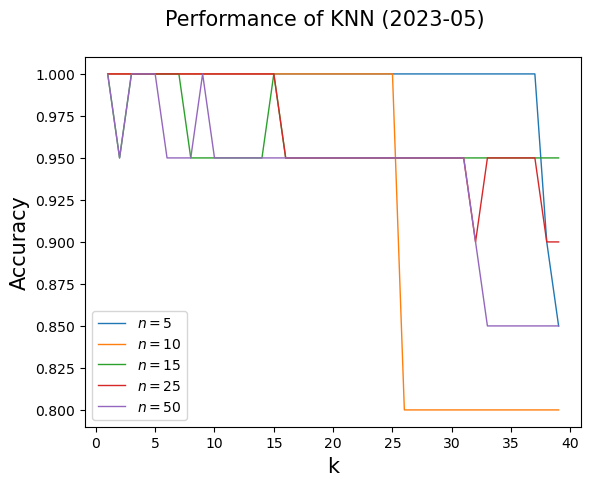

Calculating Accuracies 100 80:20 Splits for each `n`


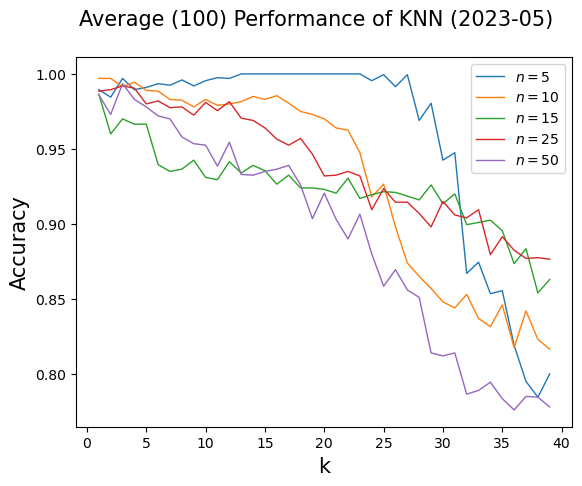

In [3]:
n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
simulation_count = 50 # number of simulations to run for each `n`
# simulation_count = 5

date = datetime.now()
print(f"Running KNN Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth / Moon Simulations
    for j in range(simulation_count):
        name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n) + moon_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

    # Generate Earth / Mars Simulations
    for j in range(simulation_count):
        name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n) + mars_sats,
            date)

        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

# for path in orb_paths_flat:
#     print(path)

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_today.png")
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({date.strftime('%Y-%m')})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_today.png")
plt.show()

### KNN on Earth/Moon and Earth/Mars Simulations (Two year Periods)

Running KNN Simulations for Year = 2020
Generating ORB Files
Running SOAP on 120 ORB files


31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to true. (-10006)
31:84: execution error: System Events got an error: Can’t set application process "SOAP" to false. (-10006)
57:66: execution error: System Events got an error: Can’t set process "SOAP" to 

Average Points in Dgm[1] is 176.0
Average Points in Dgm[1] is 343.8333333333333
Average Points in Dgm[1] is 580.875
Average Points in Dgm[1] is 1148.5
Average Points in Dgm[1] is 3188.7916666666665
Calculating 5 instances of `distance_matrix_function`


100%|██████████| 5/5 [06:36<00:00, 79.34s/it] 


Calculating Accuracies Single 80:20 Split for each `n`


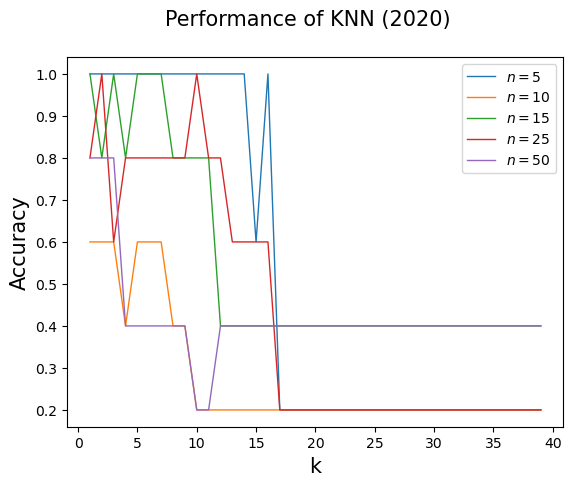

Calculating Accuracies 100 80:20 Splits for each `n`


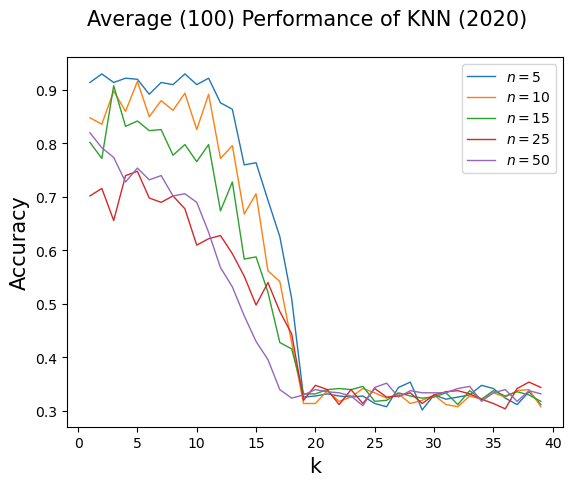

In [46]:
# n_list = [5, 10, 15, 25, 50]
# n_list = [5, 10, 15]
n_list = [5, 10, 15, 25, 50]
# simulation_count = 50 # number of simulations to run for each `n`
simulation_count = 1

year = 2020
months = 12
dates = []
for month in range(months):
    date = datetime(year + int(month / 12), month % 12 + 1, 1)
    dates.append(date)

# date = datetime.now()
print(f"Running KNN Simulations for Year = {year}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]

for i, n in enumerate(n_list):
    folder_name = f"knn-starlink-{n}-moon-{simulation_count}-mars-{simulation_count}-{year}"
    make_folder(f"{folder_base}/{folder_name}")

    for date in dates:
        starlink_sats = filter_starlink(date, starlink)

        # Generate Earth / Moon Simulations
        for j in range(simulation_count):
            name = f"starlink_moon_{date.strftime('%Y-%m')}_{j}"
            orb_filename = generate_orb_files(
                folder_name, 
                name, 
                sample_sats(starlink_sats, n) + moon_sats,
                date)

            orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
            orb_paths[i].append(orb_path)

        # Generate Earth / Mars Simulations
        for j in range(simulation_count):
            name = f"starlink_mars_{date.strftime('%Y-%m')}_{j}"
            orb_filename = generate_orb_files(
                folder_name, 
                name, 
                sample_sats(starlink_sats, n) + mars_sats,
                date)

            orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
            orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print(f"Running SOAP on {len(orb_paths_flat)} ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

EARTH, MOON, MARS = 0, 1, 2 # labels for KNN

diagrams = [{} for n in n_list]
x = [[] for n in n_list]
y = [[] for n in n_list]

for i, n in enumerate(n_list):
    # diagrams[i] = {}
    dgm_sum = 0
    for path in orb_paths[i]:
        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        graph = rp.construct_graph(contact_plan, delta = 1)    
        weighted_simplex = rp.construct_weighted_simplex(graph)
        
        zz, dgms, cells = calculate_zz_persistence(weighted_simplex)

        filename = filepath.split("/")[-1]

        diagrams[i][filename] = {
            "dgms" : dgms,
            "id" : len(x[i])
        }
        dgm_sum += len(dgms[1])

        x[i].append(filename)
        label = -1
        if "moon" in filename:
            label = MOON
        elif "mars" in filename:
            label = MARS
        else:
            label = EARTH

        y[i].append(label)

    print(f"Average Points in Dgm[1] is {dgm_sum / len(orb_paths[i])}")

dim = 1

print(f"Calculating {len(n_list)} instances of `distance_matrix_function`")

distance_matrix_functions = [None for n in n_list]
for i, n in enumerate(tqdm(n_list)):
    # print(f"\tCalculating `distance_matrix_function[{i}]`")
    distance_matrix_functions[i] = distance_matrix_lambda_function(diagrams[i], x[i], y[i], dim = dim)

print(f"Calculating Accuracies Single 80:20 Split for each `n`")

ks = range(1, 40)

accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
    
    for k in ks:
        knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
        knn.fit(x_train, y_train)
        accuracy = knn.evaluate(x_test, y_test)
        accuracies[i].append(accuracy)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Performance of KNN ({year})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_single_overlay_{year}.png")
plt.show()

m = 100 
print(f"Calculating Accuracies {m} 80:20 Splits for each `n`")

ks = range(1, 40)
accuracies = [[] for n in n_list]
for i, n in enumerate(n_list):
    for k in ks:
        k_accuracies = []
        for j in range(m):
            x_train, x_test, y_train, y_test = train_test_split(x[i], y[i], test_size=0.2)
            knn = KNeighborsClassifier(distance_matrix_functions[i], k=k)
            knn.fit(x_train, y_train)
            accuracy = knn.evaluate(x_test, y_test)
            # accuracies[i].append(accuracy)
            k_accuracies.append(accuracy)
        average = sum(k_accuracies) / len(k_accuracies)
        accuracies[i].append(average)

fig, ax = plt.subplots()
labels = []
for i, n in enumerate(n_list):
    labels.append(f"$n = {n}$")
    ax.plot(ks, accuracies[i], linewidth=1)

ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Accuracy", fontsize=15)
fig.suptitle(f"Average ({m}) Performance of KNN ({year})", fontsize=15)
plt.legend(labels)
plt.savefig(f"{folder_base}/knn_average_training_overlay_{year}.png")
plt.show()

### Slice Analysis

In [31]:
n_list = [50]
simulation_count = 30

date = datetime.now()
print(f"Running Slice Analysis Simulations on Date = {date}")

print(f"Generating ORB Files")

orb_paths = [[] for n in n_list]
for i, n in enumerate(n_list):
    
    folder_name = f"slice-starlink-{n}-sat-single"
    make_folder(f"{folder_base}/{folder_name}")

    # Generate Earth Simulations
    for j in range(simulation_count):
        name = f"starlink_{date.strftime('%Y-%m')}_{j}"
        orb_filename = generate_orb_files(
            folder_name, 
            name, 
            sample_sats(starlink_sats, n),
            date)
            
        orb_path = f"{folder_base}/{folder_name}/{orb_filename}"
        orb_paths[i].append(orb_path)

orb_paths_flat = [path for path in itertools.chain.from_iterable(orb_paths)]

print("Running SOAP on ORB files")
su.run_soap_mac(orb_paths_flat, max_workers=10)

# critical_times = [None for n in n_list]
for i, n in enumerate(n_list):

    # critical_times[i] = [None for j in orb_paths[i]]
    for j, path in enumerate(orb_paths[i]):

        filepath = path.replace(".orb", " Contact Analysis.csv")

        contact_plan = rp.contact_analysis_parser(filepath)
        tvg = rp.construct_graph(contact_plan, delta = 1)
        # critical_times[i][j] = rp.extract_critical_times(graph)
        critical_times = rp.extract_critical_times(tvg)
        sample_times = rp.sample_critical_times(critical_times)

        diameters = []
        for time in sample_times:
            graph = sanx.get_graph_slice_at(tvg, time)
            diameters.append(sanx.get_diameter(graph))
            
        # print(f"NX : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")
        print(f"NX : {n}-sats-{j} : max={max(diameters)} (out of {len(sample_times)} slices)")

        diameters = []
        for time in sample_times:
            graph = sagt.get_graph_slice_at(tvg, time)
            diameters.append(sagt.get_diameter(graph))

        # print(f"GT : {n}-sats-{j} : (min,avg,max)=({min(diameters)},{sum(diameters)/len(diameters)},{max(diameters)})")



Running Slice Analysis Simulations on Date = 2023-04-05 20:56:44.456107
Generating ORB Files
Running SOAP on ORB files
NX : 50-sats-0 : max=5 (out of 5012 slices)
NX : 50-sats-1 : max=7 (out of 5214 slices)
NX : 50-sats-2 : max=18 (out of 4282 slices)
NX : 50-sats-3 : max=5 (out of 5530 slices)
NX : 50-sats-4 : max=14 (out of 5533 slices)
NX : 50-sats-5 : max=9 (out of 5224 slices)
NX : 50-sats-6 : max=7 (out of 4701 slices)
NX : 50-sats-7 : max=14 (out of 5078 slices)
NX : 50-sats-8 : max=12 (out of 5173 slices)
NX : 50-sats-9 : max=9 (out of 5703 slices)
NX : 50-sats-10 : max=15 (out of 4754 slices)
NX : 50-sats-11 : max=7 (out of 4919 slices)
NX : 50-sats-12 : max=8 (out of 6004 slices)
NX : 50-sats-13 : max=20 (out of 4787 slices)
NX : 50-sats-14 : max=11 (out of 4748 slices)
NX : 50-sats-15 : max=10 (out of 4528 slices)
NX : 50-sats-16 : max=11 (out of 4808 slices)
NX : 50-sats-17 : max=6 (out of 5301 slices)
NX : 50-sats-18 : max=7 (out of 4138 slices)
NX : 50-sats-19 : max=9 (ou